In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import logging
from tqdm import tqdm
import sys
import seaborn as sns
from copy import deepcopy
from scipy import stats
from functools import reduce
from scipy.stats import ks_2samp

pd.options.display.max_columns = 200
sns.set_style('darkgrid')
sys.path.append('/Users/alexander_wong/Documents/playlist-success/')
%load_ext autoreload
%autoreload 2

from src.constants import *
from src.data_transformations import create_features, classify_success

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

In [3]:
# For seaborn distplots
import warnings
warnings.filterwarnings('ignore')

# Data Snapshot Preparation

## Data Snapshot Creation

In [3]:
# Deriving features from original spotify playlist data
raw_frame = pd.read_csv('../data/playlist_summary_external.txt', delimiter = "\t")
features_frame = create_features(raw_frame)

In [4]:
# Adding acoustic features (obtain from Spotify API & aggregation)
# Note that only playlists with more than 10 adjusted monthly active users had their tracks downloaded
acoustic_frame = pd.read_parquet("../data/track_features_all.parquet")
all_features_frame = pd.merge(features_frame, acoustic_frame, how='right', on='playlist_id')

In [38]:
# Keeping only a select number of features to optimize streamlit
raw_columns = list(raw_frame.columns)
raw_features = ["tracks_per_album", "artists_per_album", "users_adjusted", "title_length", "streaming_ratio_users"]
acoustic_fetures = [x for x in MODEL_NUMERICAL_FEATURES if x not in raw_columns + raw_features]

select_frame = all_features_frame[raw_columns + raw_features + acoustic_fetures]
select_frame.to_parquet("../data/streamlit_data.parquet")

In [5]:
# Itermediary checkpoint - last step before success is calculated (has all features, not just the paired down ones for Streamlit)
# all_features_frame.to_parquet("../data/playlist_features_snapshot.parquet")

## Loading the prepared snapshot

In [4]:
# Labelling success 
select_frame = pd.read_parquet("../data/streamlit_data.parquet")
success_frame = classify_success(select_frame, users_threshold=10, success_threshold=0.75)

INFO:root:# of playlists: 68352
INFO:root:# of playlists above the users_threshold: 61217
INFO:root:% of playlists removed: 7135
INFO:root:% of playlists remaining: 89.6


In [42]:
for col in success_frame.columns:
    print(col)

playlist_uri
owner
streams
stream30s
dau
wau
mau
mau_previous_month
mau_both_months
users
skippers
owner_country
n_tracks
n_local_tracks
n_artists
n_albums
monthly_stream30s
monthly_owner_stream30s
tokens
genre_1
genre_2
genre_3
mood_1
mood_2
mood_3
tracks_per_album
artists_per_album
users_adjusted
title_length
streaming_ratio_users
popularity_percentile_25p0
acousticness_percentile_25p0
danceability_percentile_25p0
duration_percentile_25p0
energy_percentile_25p0
instrumentalness_percentile_25p0
liveness_percentile_25p0
loudness_percentile_25p0
speechiness_percentile_25p0
valence_percentile_25p0
popularity_percentile_75p0
acousticness_percentile_75p0
danceability_percentile_75p0
duration_percentile_75p0
energy_percentile_75p0
instrumentalness_percentile_75p0
liveness_percentile_75p0
loudness_percentile_75p0
speechiness_percentile_75p0
valence_percentile_75p0
popularity_mean
acousticness_mean
danceability_mean
duration_mean
energy_mean
instrumentalness_mean
liveness_mean
loudness_mean
s

In [43]:
success_frame["genre_1"].value_counts()

Pop               10579
Rap                7854
Latin              5664
Indie Rock         5151
Rock               4083
Alternative        3698
R&B                3323
Dance & House      3257
Country & Folk     3228
Religious          2212
Soundtrack         2147
Electronica        1823
Punk               1658
Metal              1228
Classical           962
Jazz                800
Children's          629
Reggae              623
New Age             603
Traditional         537
Spoken & Audio      379
Easy Listening      301
-                   296
Blues               100
Other                47
Holiday              35
Name: genre_1, dtype: int64

In [44]:
success_frame.groupby(["genre_1","success_streaming_ratio_users"])["playlist_id"].count().reset_index()

KeyError: 'Column not found: playlist_id'

## Columns for analysis

In [7]:
base_cols = ["n_tracks", "n_artists", "n_albums", "tracks_per_album", "artists_per_album"]

In [81]:
percentile_cols_75 = [
    "popularity_percentile_75p0",
    "acousticness_percentile_75p0",
    "danceability_percentile_75p0",
    "duration_percentile_75p0",
    "energy_percentile_75p0",
    "instrumentalness_percentile_75p0",
    "liveness_percentile_75p0",
    "loudness_percentile_75p0",
    "speechiness_percentile_75p0",
    "valence_percentile_75p0"
]

percentile_cols_25 = [
    "popularity_percentile_25p0",
    "acousticness_percentile_25p0",
    "danceability_percentile_25p0",
    "duration_percentile_25p0",
    "energy_percentile_25p0",
    "instrumentalness_percentile_25p0",
    "liveness_percentile_25p0",
    "loudness_percentile_25p0",
    "speechiness_percentile_25p0",
    "valence_percentile_25p0"
]

percentile_cols = percentile_cols_75 + percentile_cols_25

In [9]:
mean_cols = [
    "popularity_mean",
    "acousticness_mean",
    "danceability_mean",
    "duration_mean",
    "energy_mean",
    "instrumentalness_mean",
    "liveness_mean",
    "loudness_mean",
    "speechiness_mean",
    "valence_mean"
]

In [10]:
iqr_cols = [
    "popularity_iqr",
    "acousticness_iqr",
    "danceability_iqr",
    "duration_iqr",
    "energy_iqr",
    "instrumentalness_iqr",
    "liveness_iqr",
    "loudness_iqr",
    "speechiness_iqr",
    "valence_iqr"  
]

In [11]:
var_cols =  [
    "popularity_var",
    "acousticness_var",
    "danceability_var",
    "duration_var",
    "energy_var",
    "instrumentalness_var",
    "liveness_var",
    "loudness_var",
    "speechiness_var",
    "valence_var"  
]

In [70]:
std_cols = [
    "popularity_std",
    "acousticness_std",
    "danceability_std",
    "duration_std",
    "energy_std",
    "instrumentalness_std",
    "liveness_std",
    "loudness_std",
    "speechiness_std",
    "valence_std"  
]

In [71]:
skew_cols =  [
    "popularity_skew_unbiased",
    "acousticness_skew_unbiased",
    "danceability_skew_unbiased",
    "duration_skew_unbiased",
    "energy_skew_unbiased",
    "instrumentalness_skew_unbiased",
    "liveness_skew_unbiased",
    "loudness_skew_unbiased",
    "speechiness_skew_unbiased",
    "valence_skew_unbiased"  
]

In [72]:
kurt_cols =[
    "popularity_kurt_unbiased",
    "acousticness_kurt_unbiased",
    "danceability_kurt_unbiased",
    "duration_kurt_unbiased",
    "energy_kurt_unbiased",
    "instrumentalness_kurt_unbiased",
    "liveness_kurt_unbiased",
    "loudness_kurt_unbiased",
    "speechiness_kurt_unbiased",
    "time_kurt_unbiased",
    "valence_kurt_unbiased"  
]

In [28]:
base_cols + mean_cols + iqr_cols

['n_tracks',
 'n_artists',
 'n_albums',
 'tracks_per_album',
 'artists_per_album',
 'popularity_mean',
 'acousticness_mean',
 'danceability_mean',
 'duration_mean',
 'energy_mean',
 'instrumentalness_mean',
 'liveness_mean',
 'loudness_mean',
 'speechiness_mean',
 'valence_mean',
 'popularity_iqr',
 'acousticness_iqr',
 'danceability_iqr',
 'duration_iqr',
 'energy_iqr',
 'instrumentalness_iqr',
 'liveness_iqr',
 'loudness_iqr',
 'speechiness_iqr',
 'valence_iqr']

# Historgram Distriutions

## Overall

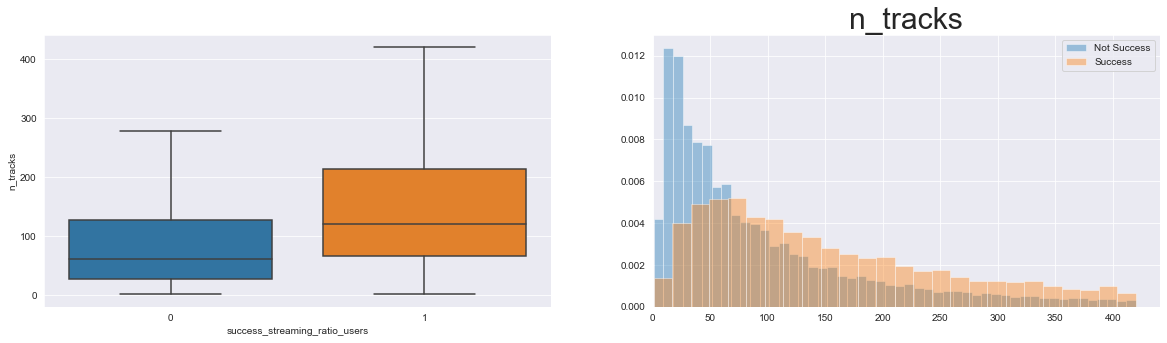

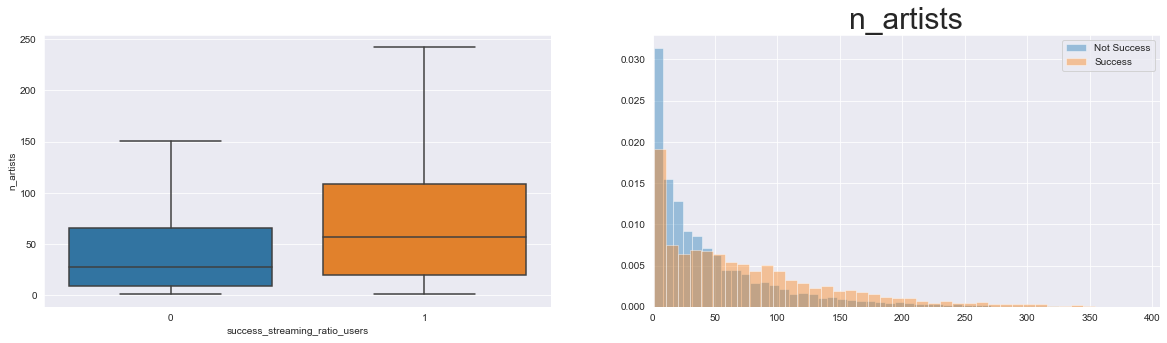

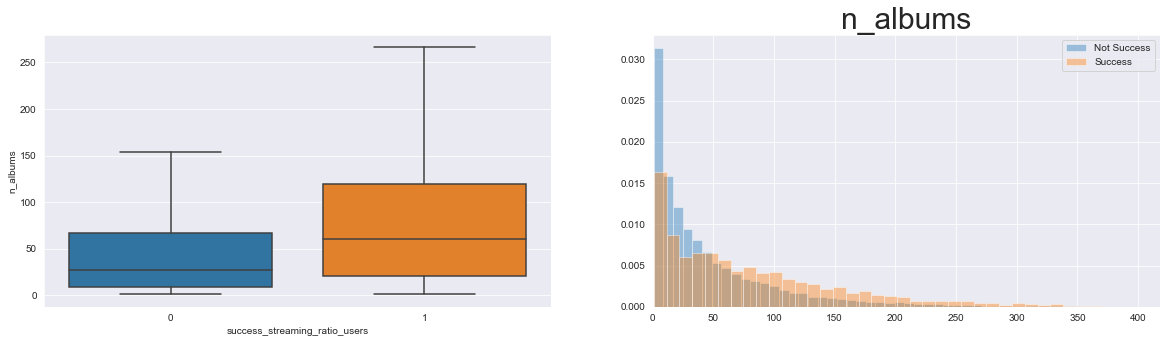

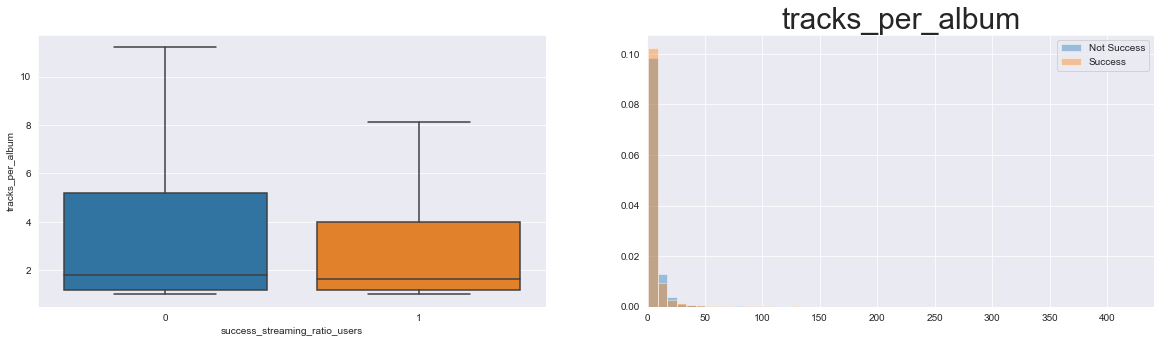

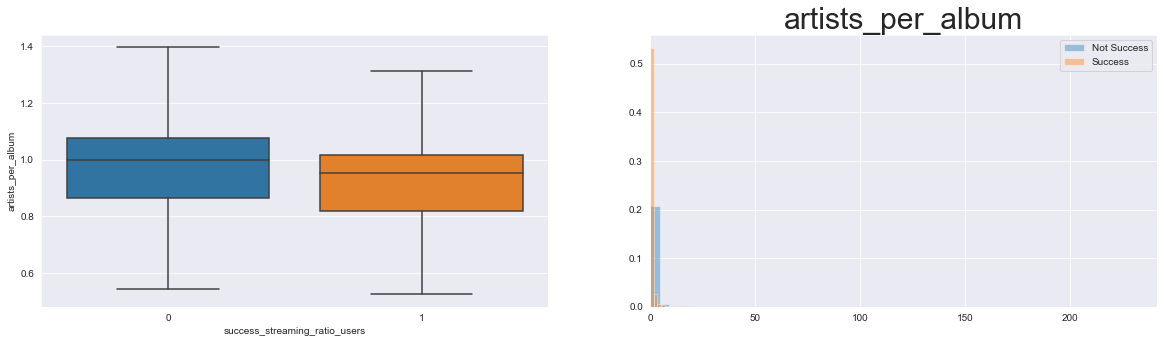

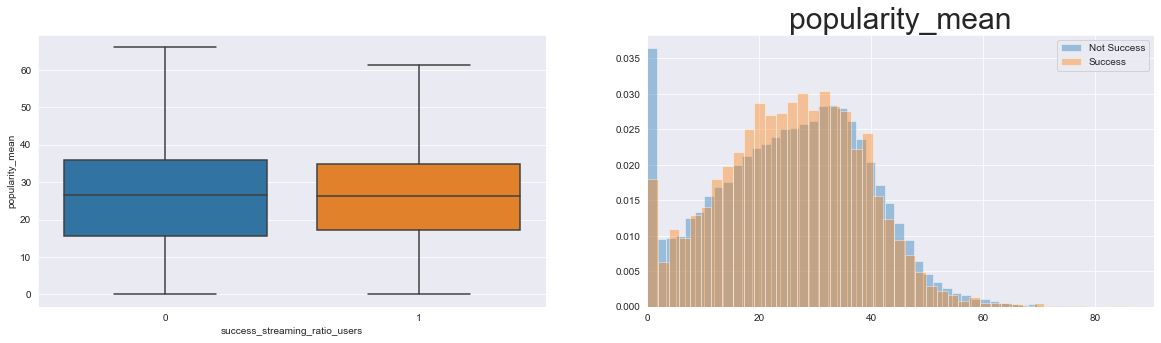

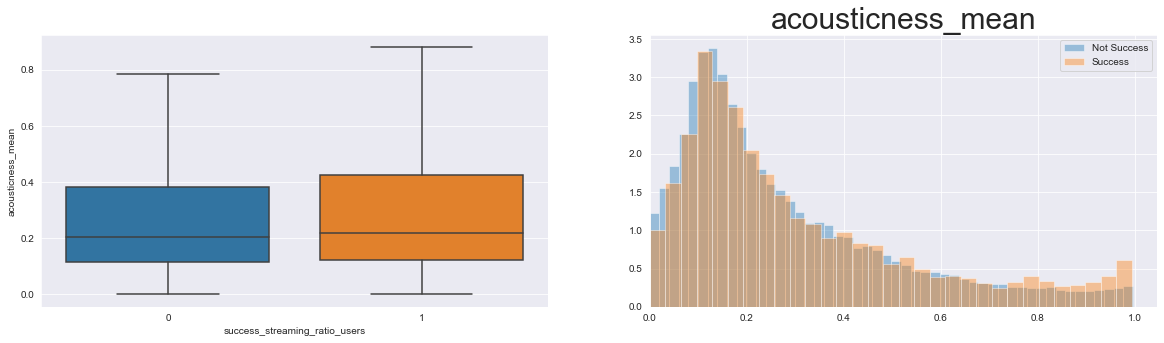

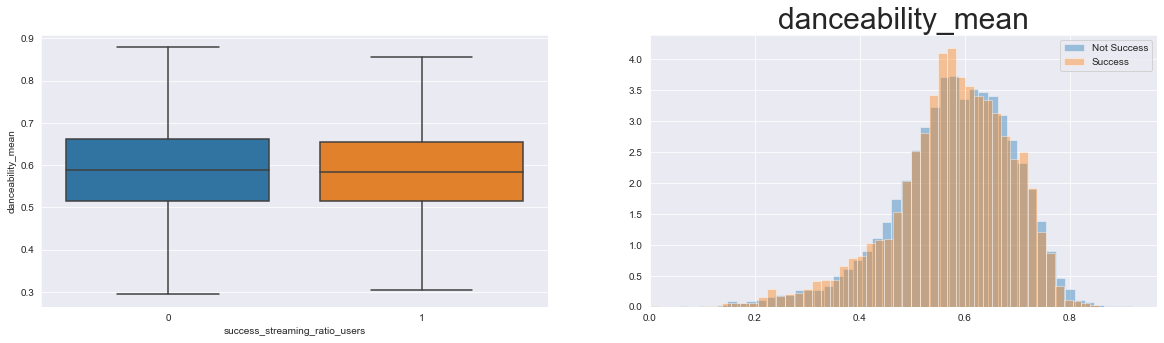

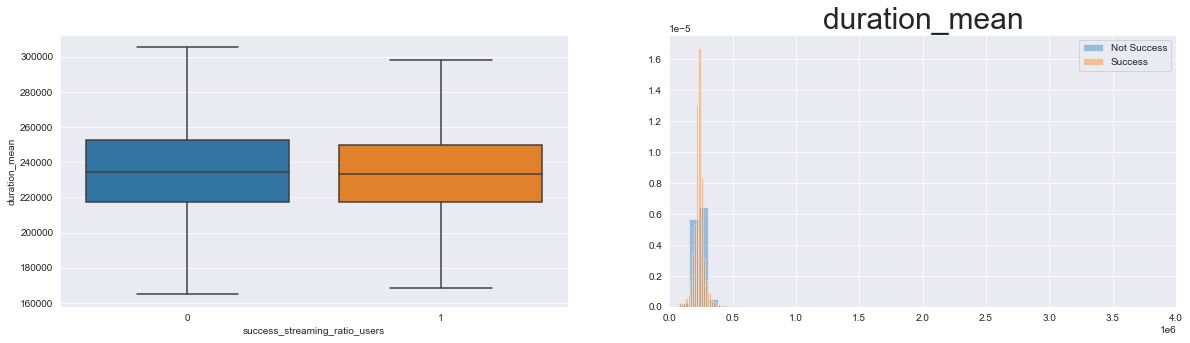

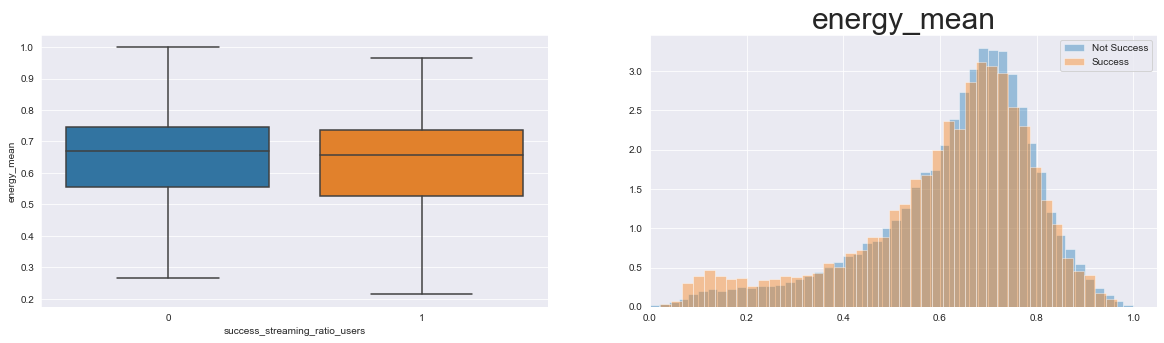

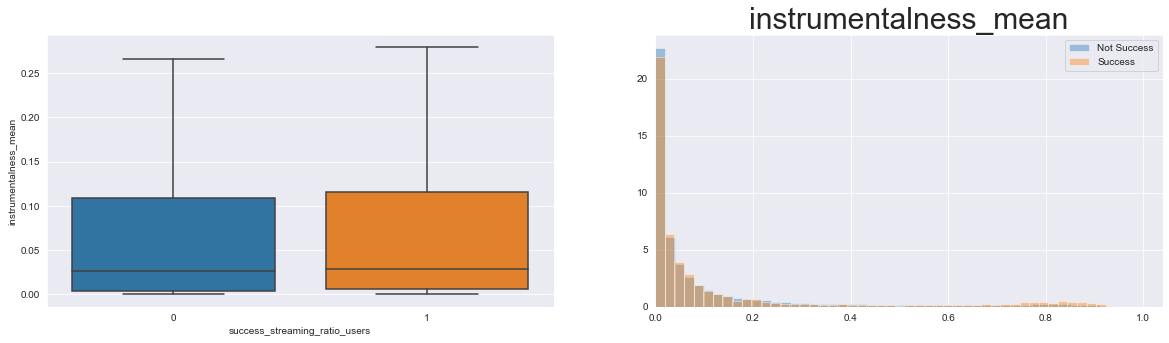

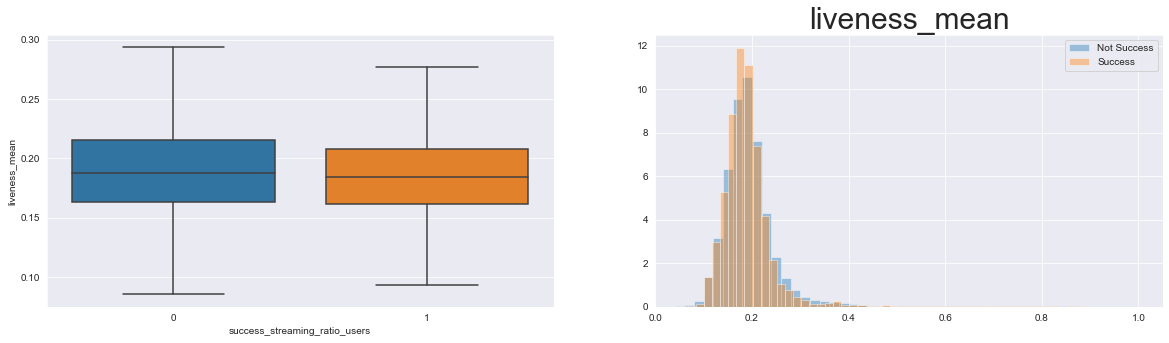

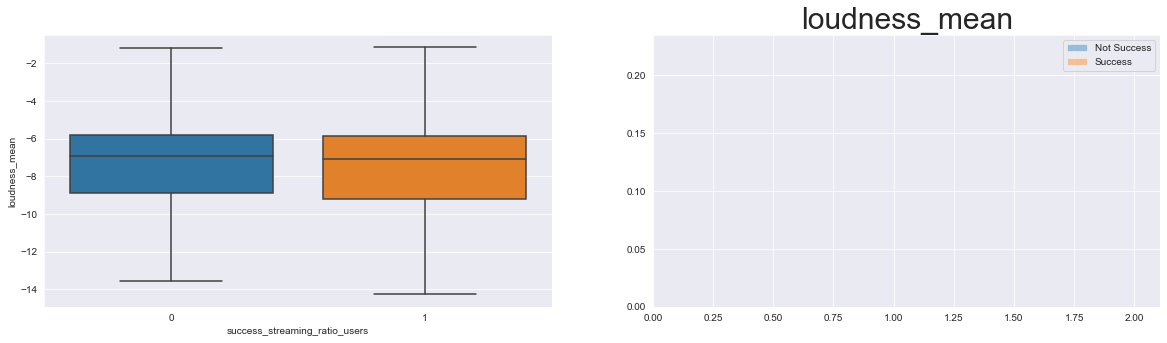

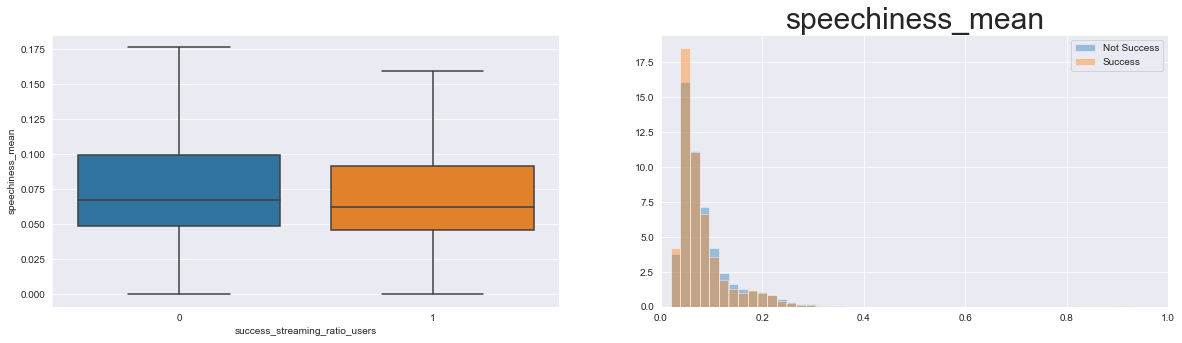

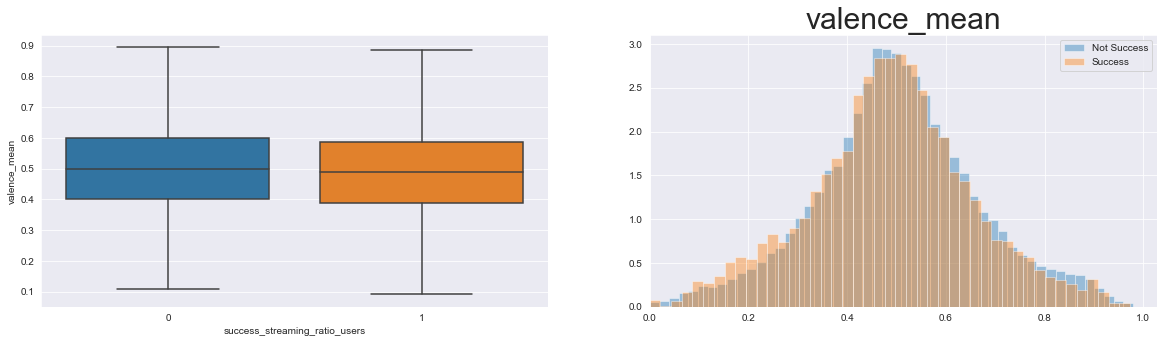

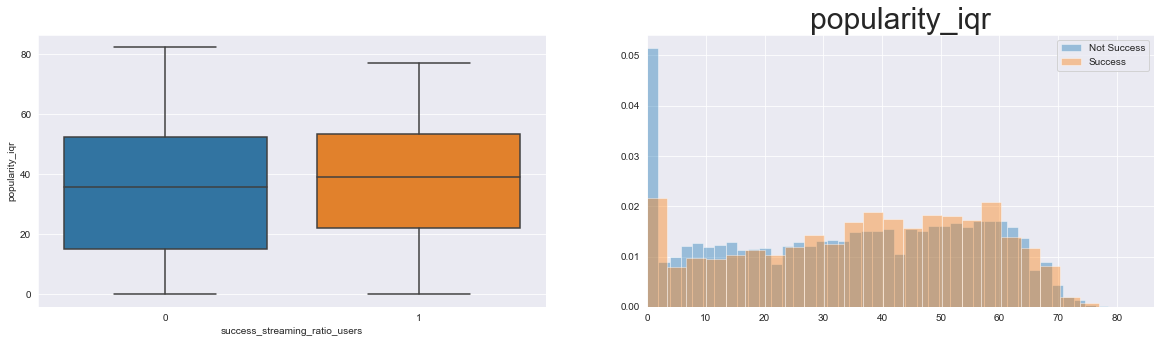

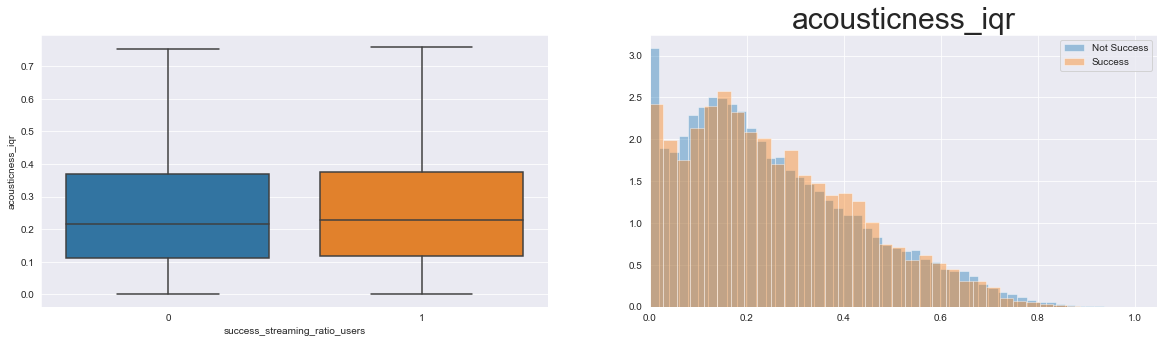

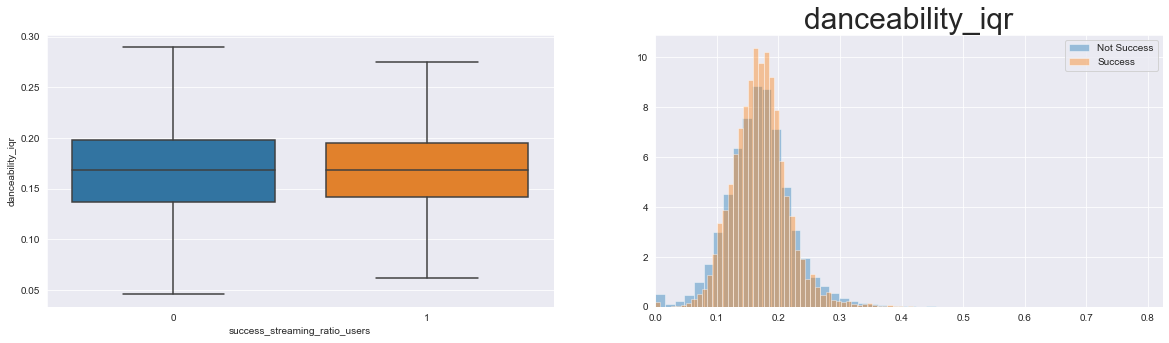

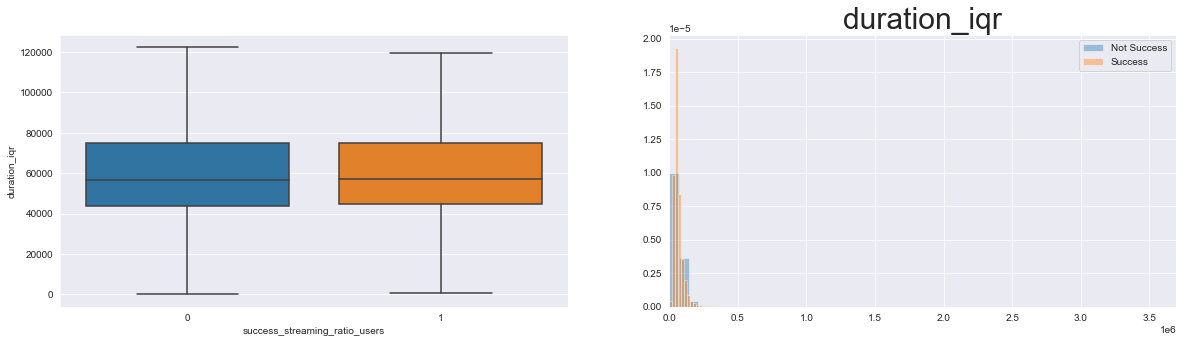

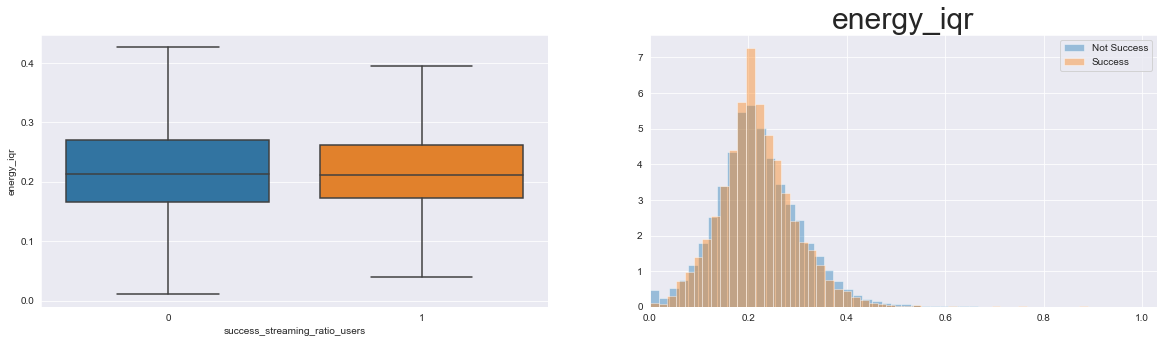

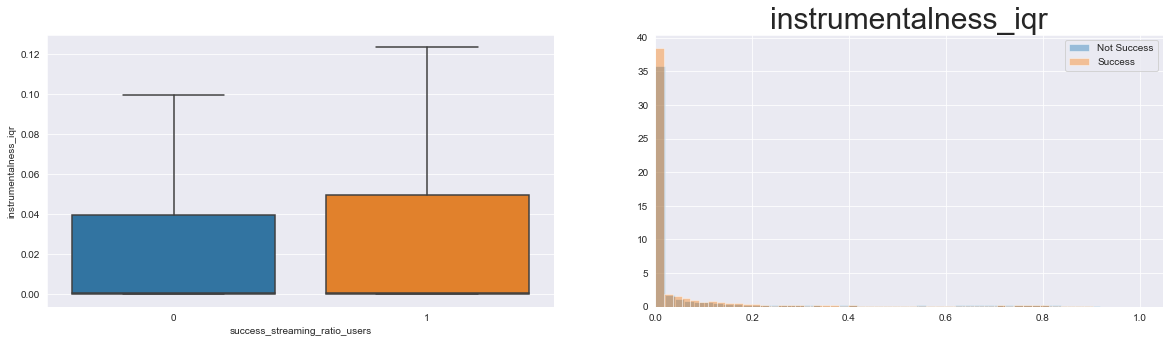

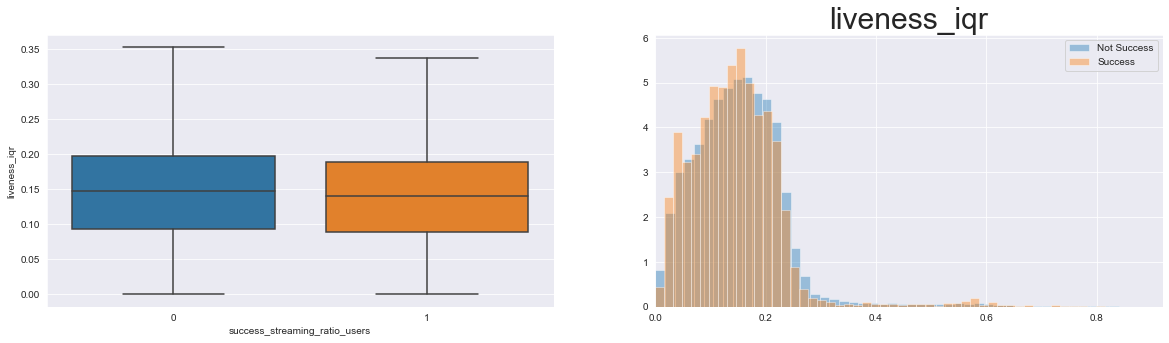

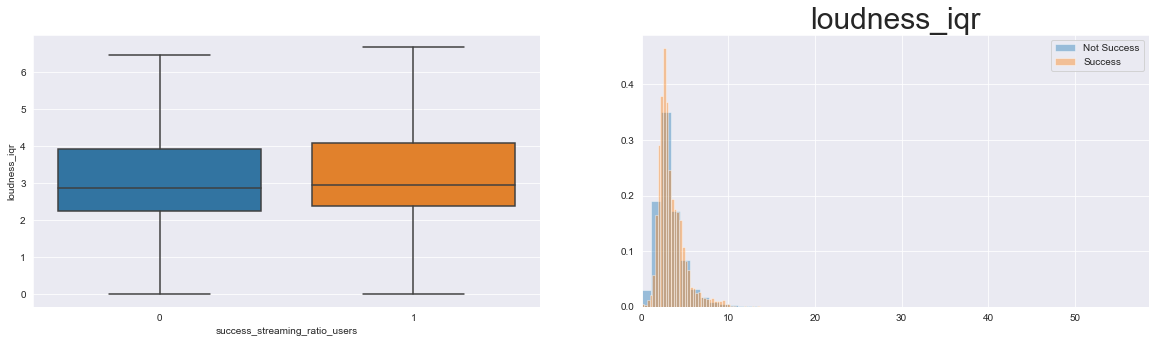

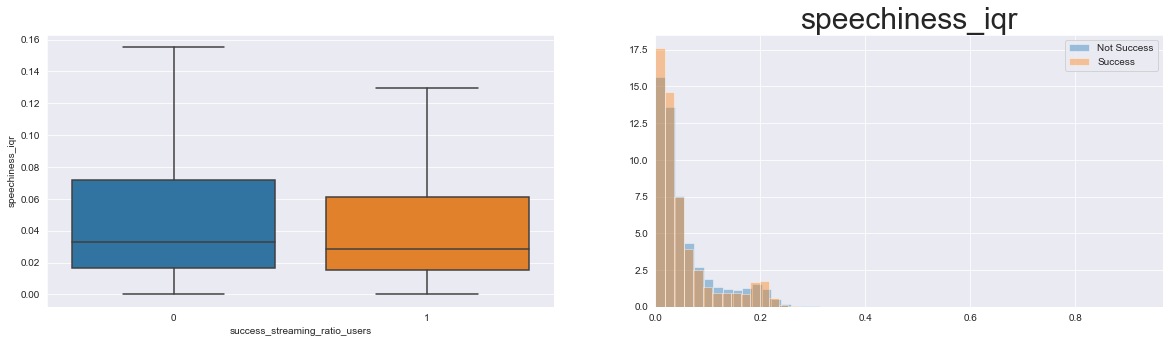

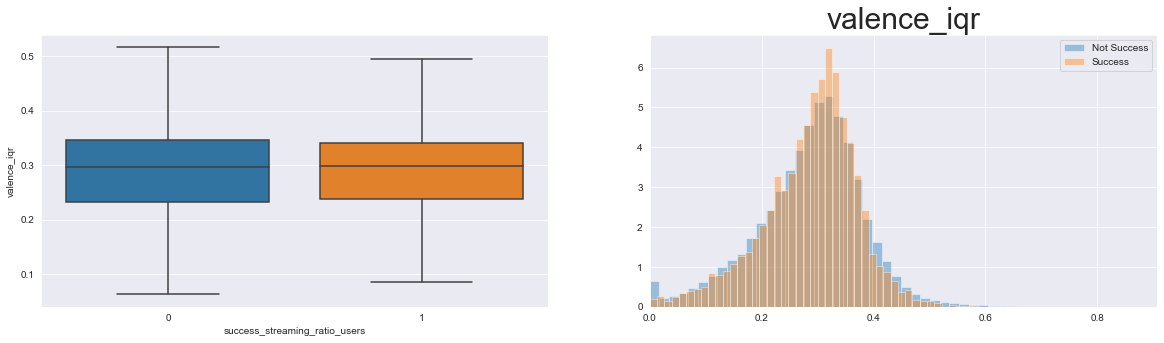

In [73]:
target_cols = base_cols + mean_cols + iqr_cols
for col in target_cols:
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    sns.boxplot(x="success_streaming_ratio_users", y=col, data=success_frame, showfliers=False,  ax=ax[0])
    sns.distplot(success_frame.loc[lambda f: f['success_streaming_ratio_users']==0][[col]], hist=True, kde=False, norm_hist = True, label='Not Success', ax=ax[1])
    sns.distplot(success_frame.loc[lambda f: f['success_streaming_ratio_users']==1][[col]], hist=True, kde=False, norm_hist = True, label='Success', ax=ax[1])
    ax[1].set_xlim(0,)
    plt.legend()
    plt.title(col, size=30)
    plt.show()

In [74]:
ks_test_overall = {}
for col in tqdm(target_cols):
    success_array = success_frame.loc[lambda f: f['success_streaming_ratio_users']==1][col].dropna()
    not_success_array = success_frame.loc[lambda f: f['success_streaming_ratio_users']==0][col].dropna()
    
    results = stats.ttest_ind(not_success_array, success_array, equal_var = True)
    ks_test_overall[col] = {
        "ks": results[0],
        "p": results[1]
    }

100%|██████████| 25/25 [00:04<00:00,  6.14it/s]


In [32]:
alpha = 0.05
sig_features = {}
not_sig_features = {}
for col, results in ks_test_overall.items():
    if results["p"] <= alpha:
        sig_features[col] = results
    else:
        not_sig_features[col] = results

In [33]:
sig_features

{'n_tracks': {'ks': -44.74876345296087, 'p': 0.0},
 'n_artists': {'ks': -37.0448570093579, 'p': 4.29579402456067e-297},
 'n_albums': {'ks': -41.768209197712196, 'p': 0.0},
 'tracks_per_album': {'ks': -4.5189938941454235, 'p': 6.225027533065063e-06},
 'artists_per_album': {'ks': 7.394127071993587, 'p': 1.4415129339075745e-13},
 'acousticness_mean': {'ks': -9.33648074286305, 'p': 1.0279850045188146e-20},
 'danceability_mean': {'ks': 2.995309931808921, 'p': 0.0027427579156460115},
 'duration_mean': {'ks': 4.785542178620833, 'p': 1.709234394203404e-06},
 'energy_mean': {'ks': 9.196293094087444, 'p': 3.817469678986588e-20},
 'instrumentalness_mean': {'ks': -8.220031479525154,
  'p': 2.0739021248571877e-16},
 'liveness_mean': {'ks': 4.432540741879871, 'p': 9.329072478802633e-06},
 'loudness_mean': {'ks': 7.210988224827927, 'p': 5.618743376094022e-13},
 'speechiness_mean': {'ks': 3.404335011226404, 'p': 0.0006636787419599193},
 'valence_mean': {'ks': 6.020139224306522, 'p': 1.752554975756345e

In [34]:
not_sig_features

{'popularity_mean': {'ks': -1.1217721290080696, 'p': 0.2619637395396112},
 'acousticness_iqr': {'ks': -1.5601078644328032, 'p': 0.11873956370151563},
 'danceability_iqr': {'ks': -1.1126705115570827, 'p': 0.26585433480941867},
 'duration_iqr': {'ks': -0.5359195073916079, 'p': 0.5920161293217379},
 'energy_iqr': {'ks': 1.8409647502096604, 'p': 0.06563156149731852},
 'valence_iqr': {'ks': -0.44601446754124635, 'p': 0.6555883731198455}}

## By Genre

In [35]:
sorted(success_frame["genre_1"].unique())

['-',
 'Alternative',
 'Blues',
 "Children's",
 'Classical',
 'Country & Folk',
 'Dance & House',
 'Easy Listening',
 'Electronica',
 'Holiday',
 'Indie Rock',
 'Jazz',
 'Latin',
 'Metal',
 'New Age',
 'Other',
 'Pop',
 'Punk',
 'R&B',
 'Rap',
 'Reggae',
 'Religious',
 'Rock',
 'Soundtrack',
 'Spoken & Audio',
 'Traditional']

In [59]:
target_cols

['n_tracks',
 'popularity_mean',
 'acousticness_mean',
 'danceability_mean',
 'duration_mean',
 'energy_mean',
 'instrumentalness_mean',
 'liveness_mean',
 'loudness_mean',
 'speechiness_mean',
 'valence_mean',
 'popularity_var',
 'acousticness_var',
 'danceability_var',
 'duration_var',
 'energy_var',
 'instrumentalness_var',
 'liveness_var',
 'loudness_var',
 'speechiness_var',
 'valence_var',
 'popularity_iqr',
 'acousticness_iqr',
 'danceability_iqr',
 'duration_iqr',
 'energy_iqr',
 'instrumentalness_iqr',
 'liveness_iqr',
 'loudness_iqr',
 'speechiness_iqr',
 'valence_iqr',
 'popularity_skew_unbiased',
 'acousticness_skew_unbiased',
 'danceability_skew_unbiased',
 'duration_skew_unbiased',
 'energy_skew_unbiased',
 'instrumentalness_skew_unbiased',
 'liveness_skew_unbiased',
 'loudness_skew_unbiased',
 'speechiness_skew_unbiased',
 'valence_skew_unbiased']

In [45]:
genre="Rap"

target_cols = MODEL_NUMERICAL_FEATURES
genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]

ks_test_overall = {}
for col in tqdm(target_cols):
    success_array = genre_frame.loc[lambda f: f['success_streaming_ratio_users']==1][col].dropna()
    not_success_array = genre_frame.loc[lambda f: f['success_streaming_ratio_users']==0][col].dropna()
    
    results = stats.ttest_ind(not_success_array, success_array, equal_var = True)
    ks_test_overall[col] = {
        "ks": results[0],
        "p": results[1]
    }

ks_frame = pd.DataFrame(ks_test_overall).T.reset_index().sort_values(by='p', ascending=True)
alpha = 0.01
ks_sig = ks_frame.loc[lambda f: f["p"]<=alpha].reset_index(drop=True)
ks_not_sig = ks_frame.loc[lambda f: f["p"]>alpha].reset_index(drop=True)

display(genre_frame["success_streaming_ratio_users"].value_counts())

100%|██████████| 46/46 [00:00<00:00, 182.41it/s]


0    5889
1    1965
Name: success_streaming_ratio_users, dtype: int64

In [110]:
ks_sig

,index,ks,p
0,n_tracks,-21.500801,1.099288e-99
1,n_albums,-19.280339,5.724425e-81
2,n_artists,-18.767028,6.651261e-77
3,title_length,5.818407,6.174353e-09
4,acousticness_percentile_75p0,-5.445263,5.329275e-08
5,duration_percentile_25p0,4.603437,4.221079e-06
6,instrumentalness_percentile_75p0,-4.520759,6.252175e-06
7,acousticness_mean,-4.210025,2.581910e-05
8,artists_per_album,4.064376,4.863089e-05
9,instrumentalness_percentile_25p0,-3.846666,1.206838e-04


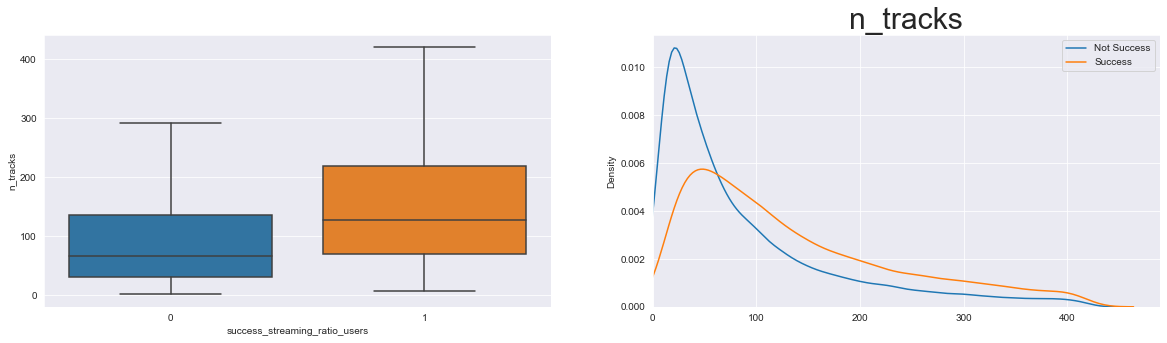

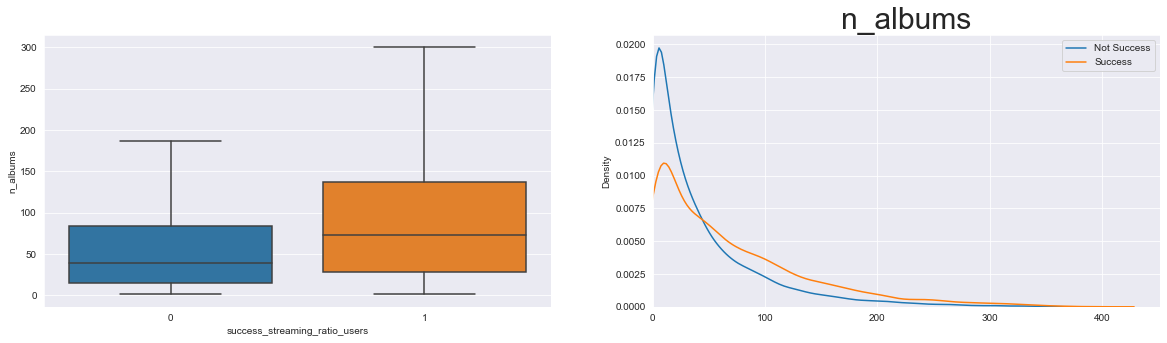

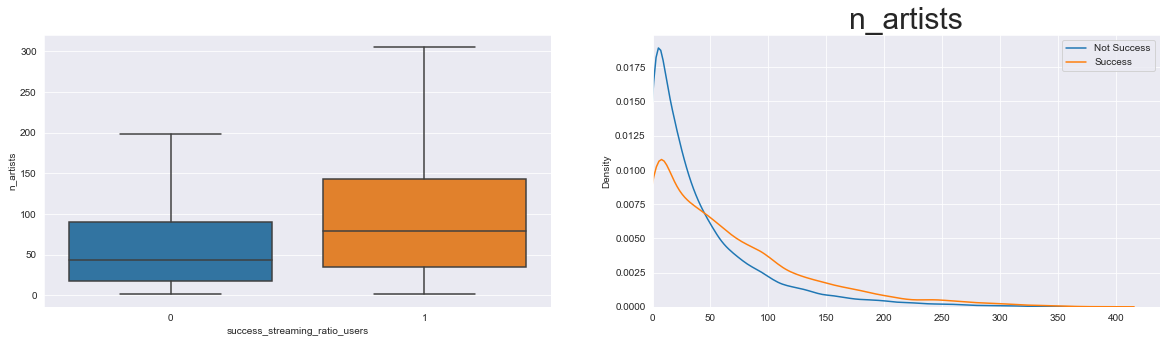

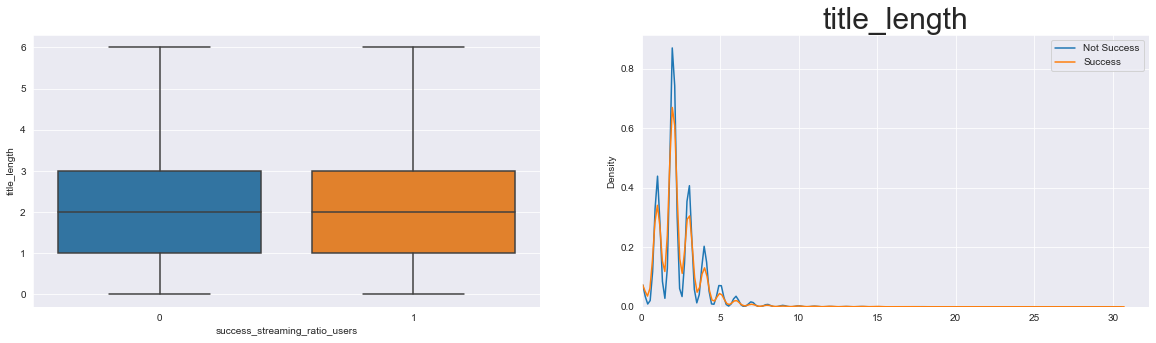

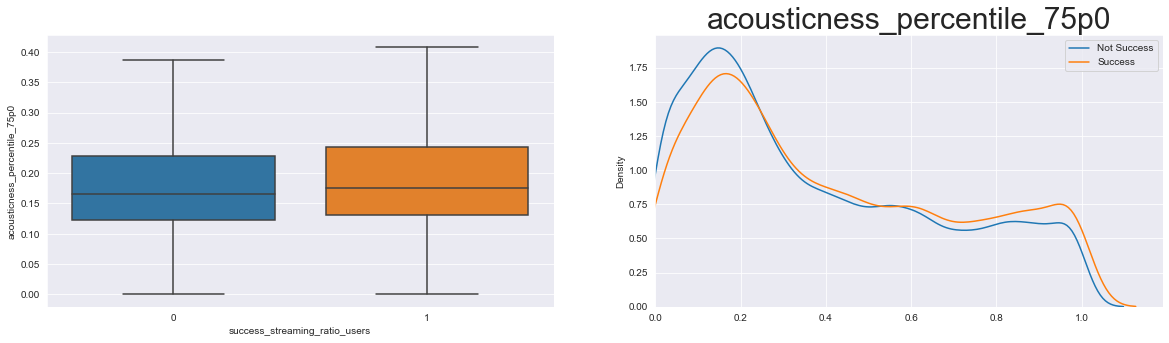

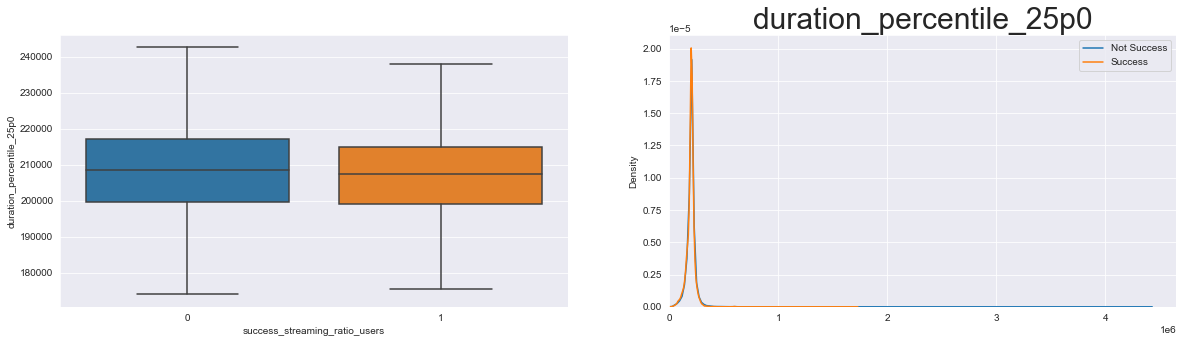

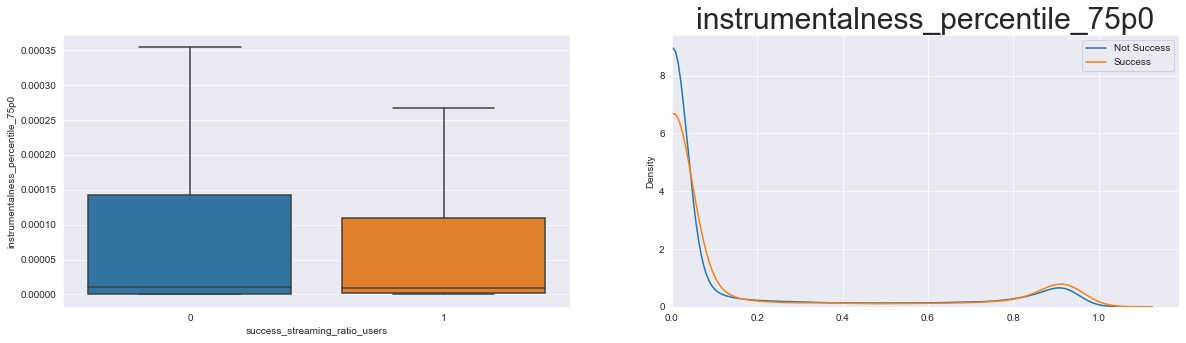

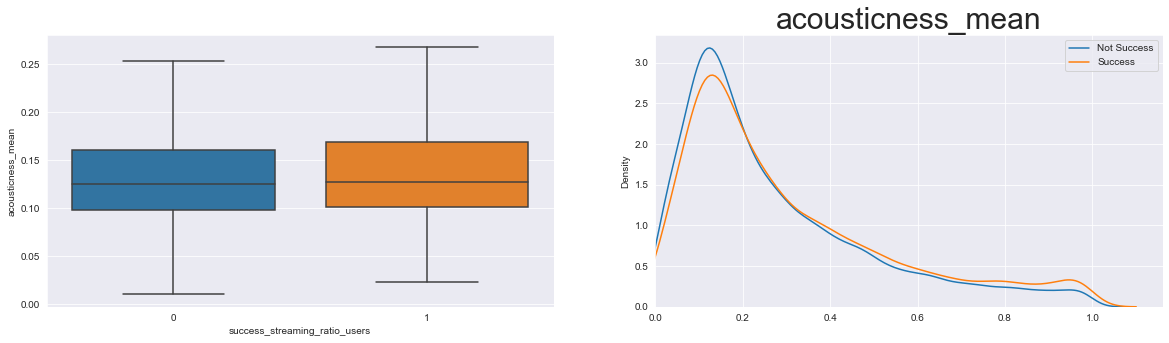

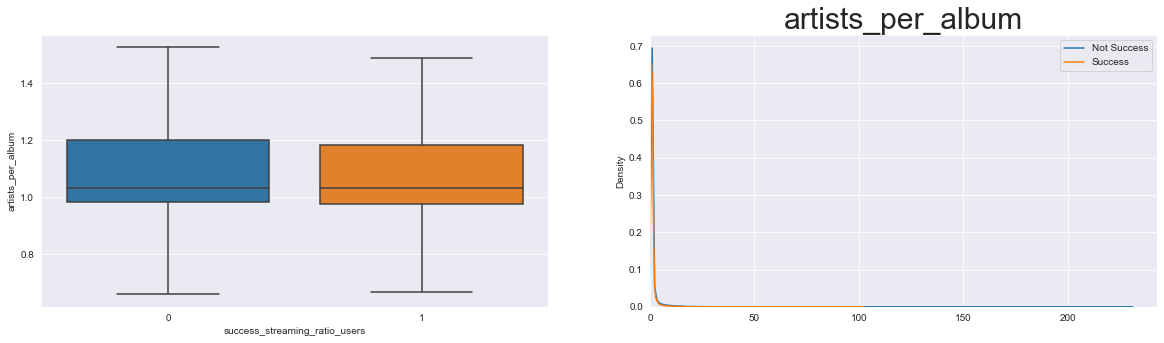

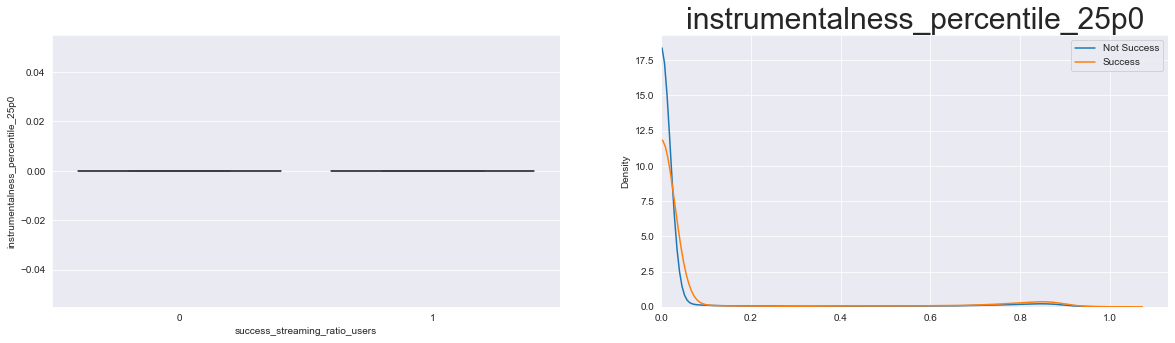

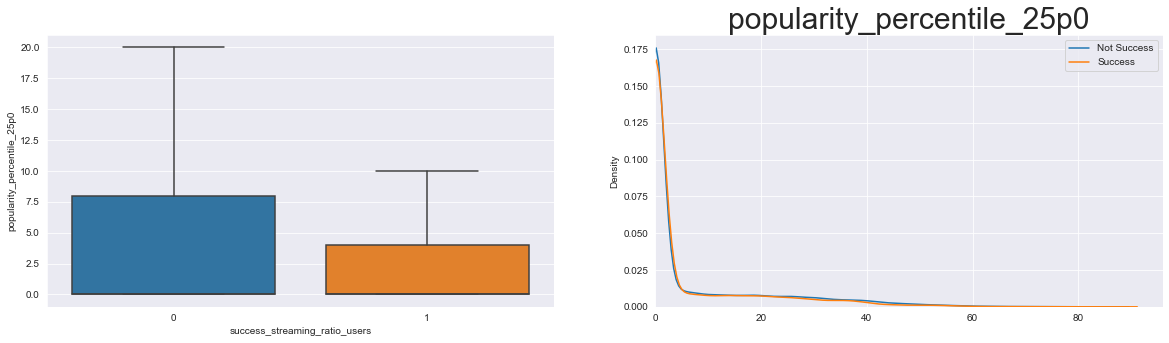

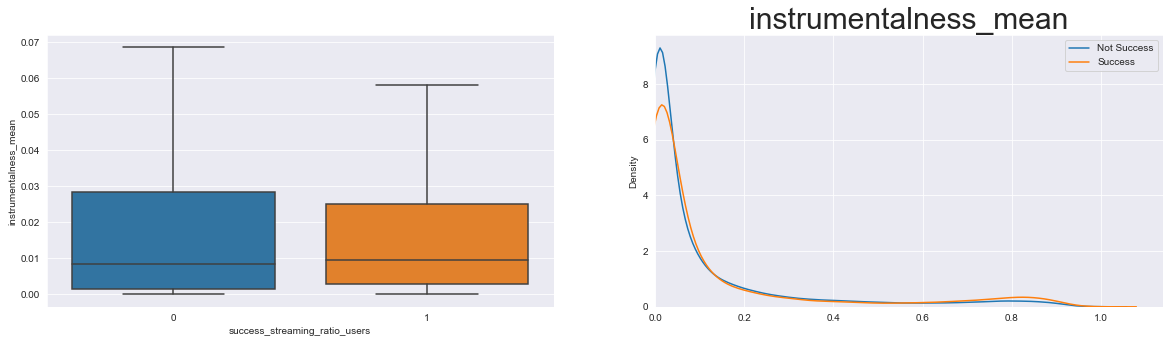

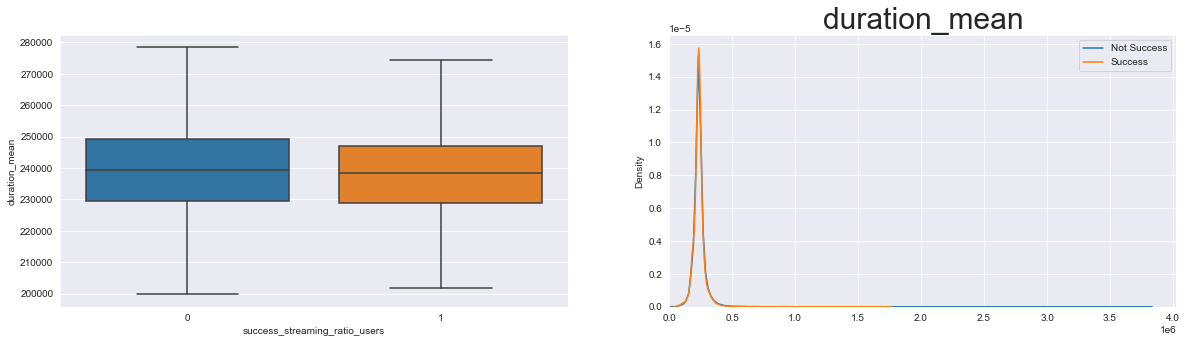

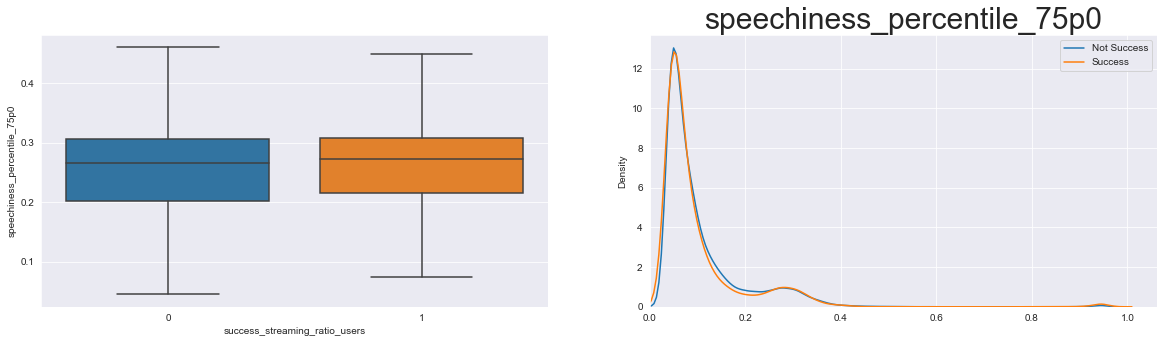

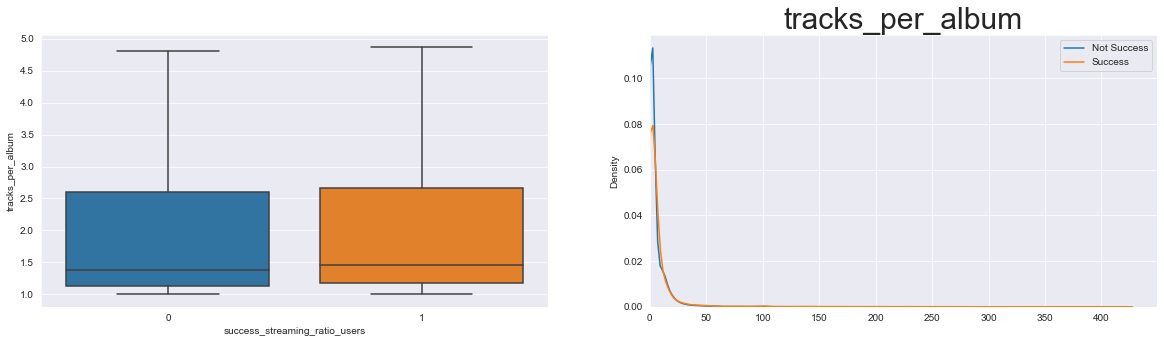

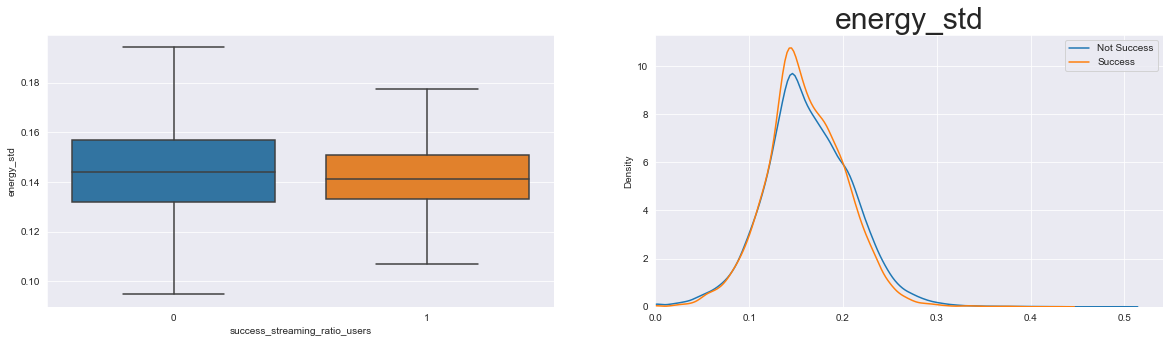

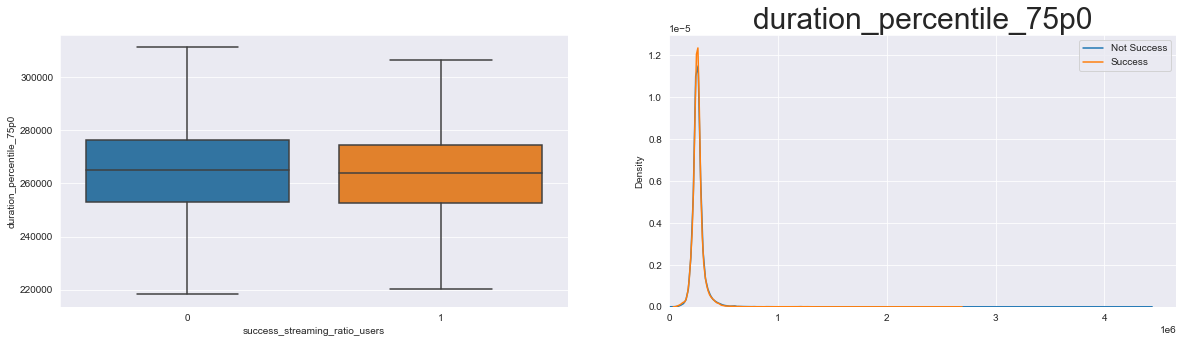

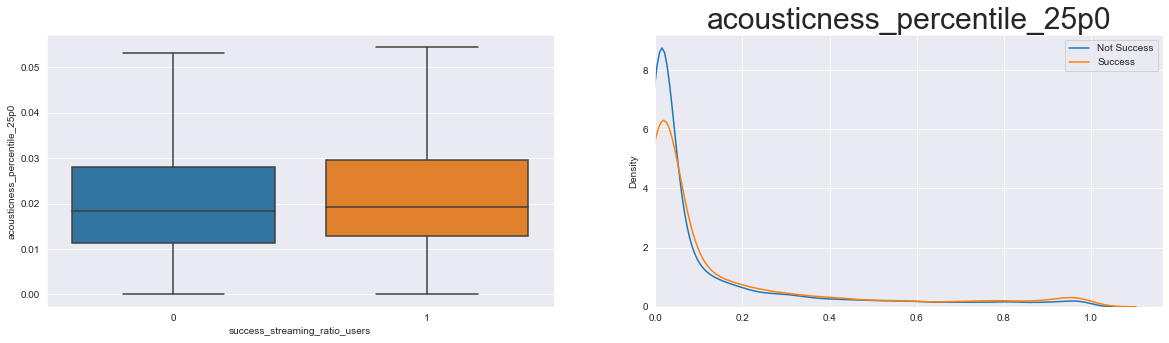

In [109]:
for i in range(len(ks_sig)):    
    col = ks_sig["index"][i]
    fig, ax =plt.subplots(1,2,figsize=(20,5))
    sns.boxplot(x="success_streaming_ratio_users", y=col, data=genre_frame, showfliers=False,  ax=ax[0])
    sns.distplot(success_frame.loc[lambda f: f['success_streaming_ratio_users']==0][[col]], hist=False, kde=True, norm_hist = True, label='Not Success', ax=ax[1])
    sns.distplot(success_frame.loc[lambda f: f['success_streaming_ratio_users']==1][[col]], hist=False, kde=True, norm_hist = True, label='Success', ax=ax[1])
    ax[1].set_xlim(0,)
    plt.legend()
    plt.title(col, size=30)
    plt.show()

# Random Forest Model & Tree Importance

In [46]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE
from src.constants import *
%load_ext autoreload
%autoreload 2


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [132]:
genre="Rap"
genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]
snapshot = genre_frame.dropna().reset_index()

logging.info(len(genre_frame))
logging.info(len(non_null_frame))

X_org = pd.get_dummies(non_null_frame[MODEL_NUMERICAL_FEATURES + MODEL_CATEGORICAL_FEATURES], columns=MODEL_CATEGORICAL_FEATURES)
y_org = snapshot["success_streaming_ratio_users"]

sm = SMOTE(random_state=69)
X_smote, y_smote = sm.fit_resample(X_org, y_org)

INFO:root:7854
INFO:root:7828


In [133]:
RF = RandomForestClassifier(n_estimators=100, verbose=1, random_state=69, oob_score=True, n_jobs=-1)
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, test_size=0.20, random_state=69)
RF.fit(X_train, y_train)

y_pred = RF.predict(X_test)
cf = confusion_matrix(y_test, y_pred)
accuracy = accuracy_score(y_test, y_pred)

[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:    0.4s finished
[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


In [116]:
display(pd.DataFrame(cf))
display(f"Model accuracy on out-of-sample test data: {round(accuracy * 100, 1)}%")

,0,1
0,1033,122
1,239,952


'Model accuracy on out-of-sample test data: 84.6%'

## Feature Importance

In [117]:
importances = pd.DataFrame({"feature": X_train.columns, "importance":RF.feature_importances_}).sort_values(by='importance', ascending=False).reset_index(drop=True)

In [118]:
importances.head(20)

,feature,importance
0,n_tracks,0.054645
1,n_artists,0.037616
2,n_albums,0.035047
3,tracks_per_album,0.027655
4,instrumentalness_std,0.026739
5,instrumentalness_mean,0.022075
6,energy_std,0.020634
7,speechiness_percentile_25p0,0.019630
8,danceability_std,0.019157
9,acousticness_percentile_25p0,0.019020


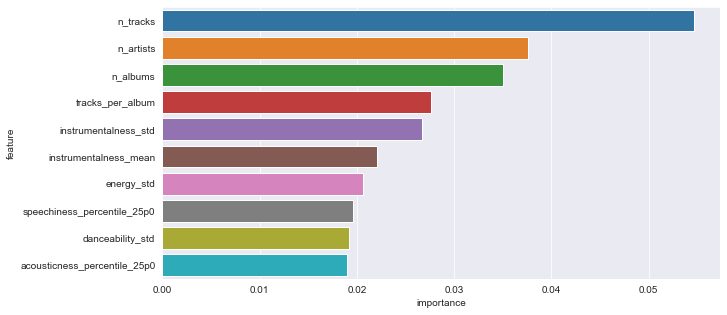

In [119]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y='feature', x='importance', data=importances.head(10))
plt.show()

## Permutation Importance

In [120]:
from sklearn.inspection import permutation_importance

In [121]:
%%time
result = permutation_importance(RF, X_train, y_train, n_repeats=5, random_state=69, n_jobs=-1)

[Parallel(n_jobs=12)]: Using backend ThreadingBackend with 12 concurrent workers.
[Parallel(n_jobs=12)]: Done  26 tasks      | elapsed:    0.0s
[Parallel(n_jobs=12)]: Done 100 out of 100 | elapsed:    0.0s finished


CPU times: user 9.48 s, sys: 5.71 s, total: 15.2 s
Wall time: 34.2 s


In [124]:
num_important_features = 10

In [128]:
frame_importance = pd.DataFrame({
    "feature": X_train.columns,
    "importance": result.importances_mean
}).sort_values(by='importance', ascending=False).head(num_important_features).reset_index(drop=True)

In [129]:
frame_importance

,feature,importance
0,mood_3_Energizing,0.006502
1,n_tracks,0.004732
2,mood_2_Cool,0.001983
3,mood_3_Cool,0.001258
4,mood_3_Sensual,0.000810
5,tracks_per_album,0.000746
6,mood_2_Defiant,0.000703
7,instrumentalness_std,0.000703
8,n_artists,0.000682
9,n_albums,0.000512


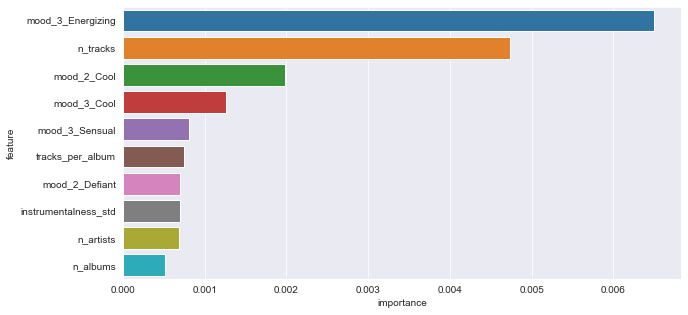

In [131]:
fig, ax = plt.subplots(figsize=(10,5))
sns.barplot(y='feature', x='importance', data=frame_importance)
plt.show()

# XGBoost Model & SHAP

## Model Tranining

In [31]:
import xgboost
from sklearn.model_selection import train_test_split
import shap

from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from imblearn.over_sampling import SMOTE

In [19]:
# Labelling success 
select_frame = pd.read_parquet("../data/streamlit_data.parquet")
success_frame = classify_success(select_frame, users_threshold=10, success_threshold=0.75)

INFO:root:# of playlists: 68352
INFO:root:# of playlists above the users_threshold: 61217
INFO:root:% of playlists removed: 7135
INFO:root:% of playlists remaining: 89.6


In [65]:
%%time
genre="Rap"
genre_frame = success_frame.loc[lambda f: f['genre_1']==genre]
snapshot = genre_frame.dropna().reset_index()

logging.info(len(genre_frame))
logging.info(len(snapshot))

X_org = pd.get_dummies(snapshot[MODEL_NUMERICAL_FEATURES + MODEL_CATEGORICAL_FEATURES], columns=MODEL_CATEGORICAL_FEATURES)
y_org = snapshot["success_streaming_ratio_users"]

sm = SMOTE(random_state=69)
X_smote, y_smote = sm.fit_resample(X_org, y_org)

train_size = 0.80
X_train, X_test, y_train, y_test = train_test_split(X_smote, y_smote, train_size=train_size, random_state=69)

X_train=X_train.reset_index(drop=True)
X_test=X_test.reset_index(drop=True)

y_train=y_train.reset_index(drop=True)
y_test=y_test.reset_index(drop=True)

model = xgboost.XGBClassifier(n_estimators=500, verbosity=0, n_jobs=-1).fit(X_train, y_train)

INFO:root:7854
INFO:root:7828


CPU times: user 1min 39s, sys: 716 ms, total: 1min 40s
Wall time: 9.16 s


## Model Performance

In [102]:
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)

y_baseline_preds = np.zeros(len(y_test))
accuracy_baseline = accuracy_score(y_test, y_baseline_preds)

print(f"Model Accuracy: {round(accuracy*100,1)}%")
print(f"Baseline Accuracy: {round(accuracy_baseline*100,1)}%")

Model Accuracy: 84.1%
Baseline Accuracy: 49.2%


In [103]:
from mlxtend.plotting import plot_confusion_matrix

In [104]:
cm = confusion_matrix(y_test, y_pred)
cm_baseline = confusion_matrix(y_test, y_baseline_preds)

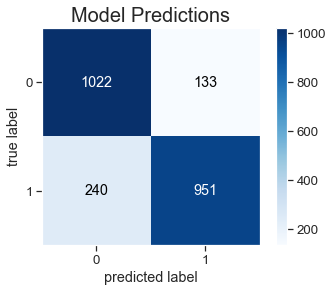

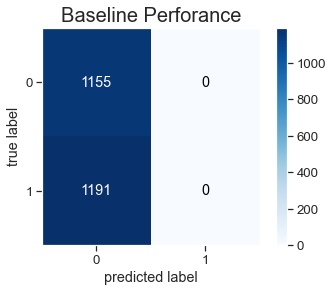

In [115]:
sns.set(font_scale=1.2)
fig, ax = plot_confusion_matrix(conf_mat=cm, show_absolute=True, colorbar=True)
plt.title("Model Predictions", size=20)
plt.show()

fig, ax = plot_confusion_matrix(conf_mat=cm_baseline, show_absolute=True, colorbar=True)
plt.title("Baseline Perforance", size=20)
plt.show()

## Overall SHAP Importances

In [96]:
%%time
explainer = shap.Explainer(model)

CPU times: user 918 ms, sys: 7.51 ms, total: 925 ms
Wall time: 927 ms


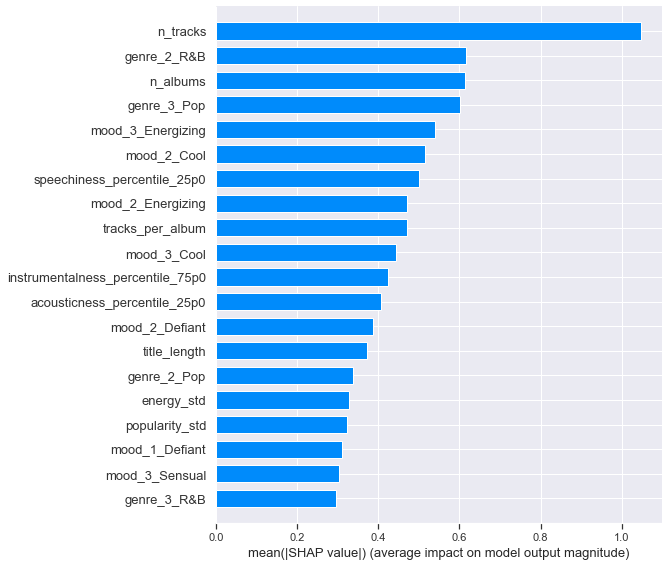

In [119]:
# Plot summary_plot as barplot:
fig, ax = plt.subplots(figsize=(10,10))
shap.summary_plot(shap_values, X_train, plot_type='bar')

In [166]:
# Distributions for each SHAP important feature
num_important = 10
vals=np.abs(shap_values.values).mean(0)
shap_importance = pd.DataFrame(list(zip(X_train.columns, vals)),columns=['feature','importance'])
shap_importance.sort_values(by=['importance'],ascending=False,inplace=True)
shap_importance = shap_importance.reset_index(drop=True).head(10)

In [168]:
display(shap_importance)

,feature,importance
0,n_tracks,1.046806
1,genre_2_R&B,0.615703
2,n_albums,0.614133
3,genre_3_Pop,0.600674
4,mood_3_Energizing,0.540306
5,mood_2_Cool,0.515891
6,speechiness_percentile_25p0,0.499475
7,mood_2_Energizing,0.471378
8,tracks_per_album,0.470139
9,mood_3_Cool,0.443541


## Individual Observations

In [157]:
success = True

if success:
    success_value = 1
else:
    success_value = 0
    
X_display = train.loc[lambda f: f['success_streaming_ratio_users']==success_value]

In [158]:
display(X_display)

,success_streaming_ratio_users,n_tracks,n_artists,n_albums,tracks_per_album,artists_per_album,title_length,popularity_percentile_25p0,acousticness_percentile_25p0,danceability_percentile_25p0,duration_percentile_25p0,energy_percentile_25p0,instrumentalness_percentile_25p0,liveness_percentile_25p0,loudness_percentile_25p0,speechiness_percentile_25p0,valence_percentile_25p0,popularity_percentile_75p0,acousticness_percentile_75p0,danceability_percentile_75p0,duration_percentile_75p0,energy_percentile_75p0,instrumentalness_percentile_75p0,liveness_percentile_75p0,loudness_percentile_75p0,speechiness_percentile_75p0,valence_percentile_75p0,popularity_mean,acousticness_mean,danceability_mean,duration_mean,energy_mean,instrumentalness_mean,liveness_mean,loudness_mean,speechiness_mean,valence_mean,popularity_std,acousticness_std,danceability_std,duration_std,energy_std,instrumentalness_std,liveness_std,loudness_std,speechiness_std,valence_std,genre_1_Rap,genre_2_-,genre_2_Alternative,genre_2_Children's,genre_2_Classical,genre_2_Country & Folk,genre_2_Dance & House,genre_2_Easy Listening,genre_2_Electronica,genre_2_Indie Rock,genre_2_Jazz,genre_2_Latin,genre_2_Metal,genre_2_New Age,genre_2_Other,genre_2_Pop,genre_2_Punk,genre_2_R&B,genre_2_Reggae,genre_2_Religious,genre_2_Rock,genre_2_Soundtrack,genre_2_Spoken & Audio,genre_2_Traditional,genre_3_-,genre_3_Alternative,genre_3_Blues,genre_3_Children's,genre_3_Classical,genre_3_Country & Folk,genre_3_Dance & House,genre_3_Easy Listening,genre_3_Electronica,genre_3_Holiday,genre_3_Indie Rock,genre_3_Jazz,genre_3_Latin,genre_3_Metal,genre_3_New Age,genre_3_Other,genre_3_Pop,genre_3_Punk,genre_3_R&B,genre_3_Reggae,genre_3_Religious,genre_3_Rock,genre_3_Soundtrack,genre_3_Spoken & Audio,genre_3_Traditional,mood_1_-,mood_1_Aggressive,mood_1_Brooding,mood_1_Cool,mood_1_Defiant,mood_1_Empowering,mood_1_Energizing,mood_1_Excited,mood_1_Fiery,mood_1_Gritty,mood_1_Lively,mood_1_Melancholy,mood_1_Other,mood_1_Peaceful,mood_1_Romantic,mood_1_Rowdy,mood_1_Sensual,mood_1_Sophisticated,mood_1_Stirring,mood_1_Tender,mood_1_Upbeat,mood_1_Urgent,mood_1_Yearning,mood_2_-,mood_2_Aggressive,mood_2_Brooding,mood_2_Cool,mood_2_Defiant,mood_2_Easygoing,mood_2_Empowering,mood_2_Energizing,mood_2_Excited,mood_2_Fiery,mood_2_Gritty,mood_2_Lively,mood_2_Melancholy,mood_2_Other,mood_2_Peaceful,mood_2_Romantic,mood_2_Rowdy,mood_2_Sensual,mood_2_Sentimental,mood_2_Serious,mood_2_Somber,mood_2_Sophisticated,mood_2_Upbeat,mood_2_Urgent,mood_2_Yearning,mood_3_-,mood_3_Aggressive,mood_3_Brooding,mood_3_Cool,mood_3_Defiant,mood_3_Easygoing,mood_3_Empowering,mood_3_Energizing,mood_3_Excited,mood_3_Fiery,mood_3_Gritty,mood_3_Lively,mood_3_Melancholy,mood_3_Other,mood_3_Peaceful,mood_3_Romantic,mood_3_Rowdy,mood_3_Sensual,mood_3_Sentimental,mood_3_Serious,mood_3_Somber,mood_3_Sophisticated,mood_3_Tender,mood_3_Upbeat,mood_3_Urgent,mood_3_Yearning
1,1,139,90,80,1.815186,1.129875,2,0.000000,0.029039,0.604662,213222.716432,0.573180,0.000000,0.109916,-8.541249,0.123337,0.381357,45.316677,0.257731,0.782148,287643.342366,0.782997,0.000010,0.325999,-5.285183,0.289149,0.676668,23.761221,0.176072,0.677912,258484.539363,0.669681,0.003800,0.235911,-7.189366,0.215571,0.539603,25.830133,0.183252,0.135349,75109.496381,0.143635,0.018443,0.165497,2.895523,0.115638,0.206535,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,1,168,110,105,1.721071,1.049747,1,1.607191,0.010213,0.635072,195937.704726,0.562535,0.000000,0.105402,-7.490517,0.077696,0.268108,60.410786,0.114045,0.827867,255001.835896,0.810222,0.015973,0.297714,-4.663057,0.281679,0.549902,33.897060,0.093838,0.722290,227129.532528,0.681974,0.067913,0.214881,-6.149091,0.188501,0.413468,29.081683,0.143275,0.137411,48085.294870,0.155198,0.149965,0.163475,2.197798,0.124536,0.197221,1,0,0,0,0,0,0,0

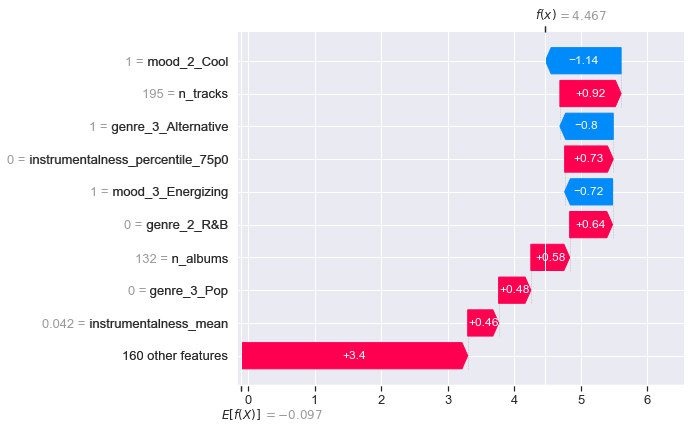

In [159]:
row = 5
shap.plots.waterfall(shap_values[row])

In [162]:
shap.initjs()
shap.plots.force(shap_values[row])